In [4]:
import pandas as pd
import numpy as np
import geopandas as gp
import seaborn as sn
import datetime as dt
import pylab as pl
import urllib.request
from urllib.request import urlretrieve
import zipfile
import statsmodels as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
pd.set_option('display.max_columns', 500)

# SECTION 1. 311 DATA MUNGING 

In [6]:
# Get the data form the open data website
# Just run if you do not have already one of the clean datasets, it takes a while to get the data
df = pd.read_csv("https://data.cityofnewyork.us/api/views/erm2-nwe9/rows.csv?accessType=DOWNLOAD")

C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8,17,18,31,32,33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [85]:
#Pulling takes a lot of time, so use the following code to just read from csv.
#df.to_csv("311Pull.csv")
#df = pd.read_csv("311Pull.csv")

In [7]:
# Visualize the first 5 observations of the data
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,20017982,03/12/2011 01:54:00 PM,03/14/2011 12:00:00 PM,DSNY,BCC - Brooklyn South,Litter Basket / Request,10 Litter Basket / Request,Sidewalk,11229,2320 AVENUE U,AVENUE U,EAST 23 STREET,EAST 24 STREET,NaN,NaN,ADDRESS,BROOKLYN,NaN,DSNY Garage,Closed,NaN,The Department of Sanitation has investigated ...,03/14/2011 12:00:00 PM,15 BROOKLYN,3.073560e+09,BROOKLYN,998622.0,157775.0,PHONE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.599721,-73.948246,"(40.599720547957965, -73.9482459150557)"
1,20017983,03/12/2011 12:10:00 PM,03/15/2011 12:00:00 PM,DSNY,A - Brooklyn,Recycling Enforcement,ER1 Resident Recyc. (Owner/Manager,Sidewalk,11235,2416 EAST 23 STREET,EAST 23 STREET,AVENUE X,AVENUE Y,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Closed,NaN,The Department of Sanitation investigated this...,03/15/2011 12:00:00 PM,15 BROOKLYN,NaN,BROOKLYN,998923.0,155148.0,PHONE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.592509,-73.947168,"(40.59250947060378, -73.94716770910988)"
2,20017984,03/12/2011 03:59:00 PM,03/21/2011 12:00:00 PM,DSNY,A - Brooklyn,Recycling Enforcement,ER1 Resident Recyc. (Owner/Manager,Sidewalk,11229,1825 MADISON PLACE,MADISON PLACE,AVENUE R,FILLMORE AVENUE,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Closed,NaN,The Department of Sanitation investigated this...,03/21/2011 12:00:00 PM,18 BROOKLYN,3.084730e+09,BROOKLYN,1001042.0,161220.0,PHONE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.609172,-73.939523,"(40.60917211364392, -73.93952284644747)"
3,20017985,03/12/2011 10:05:00 AM,03/15/2011 12:00:00 PM,DSNY,A - Brooklyn,Recycling Enforcement,ER2 Resident Recyc. (Tenant),Sidewalk,11218,1406 35 STREET,35 STREET,14 AVENUE,DAHILL ROAD,NaN,NaN,ADDRESS,BROOKLYN,NaN,NaN,Closed,NaN,The Department of Sanitation investigated this...,03/15/2011 12:00:00 PM,12 BROOKLYN,3.053500e+09,BROOKLYN,989401.0,172934.0,PHONE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.641339,-73.981439,"(40.64133899963967, -73.98143949689891)"
4,20018028,03/12/2011 01:31:00 PM,03/12/2011 01:31:00 PM,DSNY,BCC - Queens East,Missed Collection (All Materials),1 Missed Collection,Sidewalk,11366,73-34 190 STREET,190 STREET,73 AVENUE,75 AVENUE,NaN,NaN,ADDRESS,FRESH MEADOWS,NaN,DSNY Garage,Closed,NaN,The Department of Sanitation picked up the ite...,03/12/2011 01:31:00 PM,08 QUEENS,4.071770e+09,QUEENS,1044912.0,206538.0,PHONE,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.733368,-73.781116,"(40.733367736834275, -73.78111562676301)"


In [8]:
# Look at the shape of the data
df.shape

(9341942, 41)

We can see how big the entire dataset is! We need some cleaning. First just get the years we are interested in (2013, 2014 and 2015) then get rid of some columns we really do not need, then just keep the Noise complaints that are the main focus of our work.

In [9]:
# Visualize all the columns the data has
df.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [10]:
# Visualize the complaint types so that we get only noise
df["Complaint Type"].unique()

array(['Litter Basket / Request', 'Recycling Enforcement',
       'Missed Collection (All Materials)',
       'General Construction/Plumbing', 'Other Enforcement',
       'Dirty Conditions', 'Vacant Lot', 'Overflowing Litter Baskets',
       'Sanitation Condition', 'Derelict Bicycle', 'Hazardous Materials',
       'Industrial Waste', 'Noise', 'Sewer', 'Water System',
       'Street Condition', 'Derelict Vehicles',
       'Sweeping/Missed-Inadequate', 'Root/Sewer/Sidewalk Condition',
       'Highway Condition', 'Adopt-A-Basket', 'Illegal Tree Damage',
       'New Tree Request', 'Building/Use', 'Lead', 'Snow', 'Plumbing',
       'Air Quality', 'Overgrown Tree/Branches', 'Graffiti',
       'Damaged Tree', 'Electrical', 'Plant', 'Water Conservation',
       'BEST/Site Safety', 'Elevator',
       'Special Projects Inspection Team (SPIT)',
       'Collection Truck Noise', 'Cranes and Derricks', 'Water Quality',
       'Investigations and Discipline (IAD)', 'Boilers',
       'Traffic Signal C

In [11]:
# Check the variable type of Created Date.
type(df['Created Date'].iloc[1])

str

In [12]:
noise = df[df["Complaint Type"] == "Noise"]

In [13]:
# Convert to date time
noise['Created Date'] = pd.to_datetime(noise['Created Date'])

C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
# Set the maximum and minimum dates we want in our dataset
start_date = '01/01/2013'
end_date = '12/31/2015'

noise =  noise[noise["Created Date"]>start_date]
noise =  noise[noise["Created Date"]<end_date]

In [15]:
# See how many observations we dropped
print (df.shape)
print (noise.shape)

(9341942, 41)
(146301, 41)


In [16]:
noise.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [17]:
# We keep only the columns we are interested in
noise = noise[["Unique Key", "Created Date", "Agency", "Agency Name", 
         "Complaint Type", "Descriptor", "Incident Zip", "Community Board", "Borough", "School Name", 
         "School Number", "School Code", "School or Citywide Complaint", "Latitude", "Longitude", "Location"]]

KeyError: "['School Name' 'School Number' 'School Code'\n 'School or Citywide Complaint'] not in index"

In [ ]:
noise.shape

In [ ]:
# We are only interested in observations we can geo localize so we check if the column has nan values.
noise1 = noise[noise['Location']=="NaN"]

In [ ]:
noise.shape

In [ ]:
noise1.shape

# It doesn't have any NaN values. How great!

In [ ]:
# We save the data as a csv file in case we want to reload it without spending so much time
noise.to_csv('311data.csv')

In [ ]:
noise.head()

In [ ]:
noise.shape

In [ ]:
# We group the noise complaints in differen time subsets in order to visualize them
grph = noise.groupby(noise["Created Date"].dt.hour).count()
grpd = noise.groupby(noise["Created Date"].dt.weekday).count()
grpw = noise.groupby(noise["Created Date"].dt.week).count()
grpy = noise.groupby(noise["Created Date"].dt.year).count()

In [ ]:
grpd.head(1)

In [ ]:
fig = plt.figure(figsize=(7,4))

wd = np.arange(3)
ax1 =plt.bar(wd, grpy["Unique Key"])
plt.xticks(wd, ('2013', '2014', '2015'))
pl.title("Complaints by year")
pl.ylabel("Number of complaints")

fig = plt.figure(figsize=(7,4))

wd = np.arange(7)
ax1 =plt.bar(wd, grpd["Unique Key"])
plt.xticks(wd, ('Monday', 'Tuesday', 'Wednesday', 'Thursday', "Friday", "Saturday", "Sunday"))
pl.title("Complaints by weekday")
pl.ylabel("Number of complaints")

fig = plt.figure(figsize=(7,4))

x = np.arange(24)
ax2 = plt.bar(x, grph["Unique Key"])
plt.xticks(x, ('0', '1', '2', '3', "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14",
              "15", "16", "17", "18", "19", "20", "21", "22", "23"))
pl.title("Complaints by hour")
pl.ylabel("Number of complaints")
pl.xlabel("hours of the day")

fig = plt.figure(figsize=(7,4))
ax3 = plt.figure(figsize=(7,4))
pl.plot(grpw["Unique Key"], "--o")
pl.title("Complaints by week of the year")
pl.ylabel("Number of complaints")
pl.xlabel("week of the year")

pl.figure(figsize=(7,7))
ax4 = pl.scatter(noise.Longitude, noise.Latitude, s = 0.1)
pl.title("Complaints in NYC")

In [ ]:
# We drop Saturdays and Sundays because kids do not go to school those days
noise =  noise[noise["Created Date"].dt.weekday!=6]
noise =  noise[noise["Created Date"].dt.weekday!=7]

In [ ]:
print ("This is our final 311 database complaint database shape:", noise.shape)

In [ ]:
# Because our school results are by year then we also want our noise complaints by year
noise2013 = noise[noise["Created Date"].dt.year == 2013]
noise2014 = noise[noise["Created Date"].dt.year == 2014]
noise2015 = noise[noise["Created Date"].dt.year == 2015]

In [ ]:
# We create three different datasets of noise complaints (1 by year in order to groupby census tract)
noise2013.to_csv("noise2013.csv")
noise2014.to_csv("noise2014.csv")
noise2015.to_csv("noise2015.csv")

### NOTE: in order to count the number of complaints by Census Tract we used "Carto" using the analysis of counting points inside geometries. The geometries were the census tracts provided by new york city open data. It will we used in the following data processing.  

In [ ]:
# We read the resulting datasets that contain the number of complaints by Census Tract
noise_13 = pd.read_csv("noisebyct2013.csv")
noise_14 = pd.read_csv("noisebyct2014.csv")
noise_15 = pd.read_csv("noisebyct2015.csv")

In [ ]:
print (noise_13.shape)
print (noise_14.shape)
print (noise_15.shape)

In [ ]:
# This is a way to visualize NYC that professor Federica Bianco created, it is basically a choropleth with variations.
urllib.request.urlretrieve("https://raw.githubusercontent.com/fedhere/choroplethNYC/master/choroplethNYC.py","choroplethNYC.py")
import choroplethNYC as cp

In [ ]:
# Make the datasets geo data frames in order to map them
noise_13_ = gp.GeoDataFrame(noise_13)
noise_14_ = gp.GeoDataFrame(noise_14)
noise_15_ = gp.GeoDataFrame(noise_15)

In [ ]:
#we unzip the census tract shapefile (it will be attached with the code in a separate file)
zip_ref = zipfile.ZipFile("2010 Census Tracts.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
# We read the file as a geodataframe
ct = gp.GeoDataFrame.from_file("geo_export_19d388ec-f34e-4b0d-b74d-a31e738347e7.shp")

In [ ]:
ct.head(1)

In [ ]:
noise_13_.columns

In [ ]:
noise_13_["boro_ct201"] = noise_13_["boro_ct201"].astype(str)
noise_14_["boro_ct201"] = noise_14_["boro_ct201"].astype(str)
noise_15_["boro_ct201"] = noise_15_["boro_ct201"].astype(str)

ct["boro_ct201"] = ct["boro_ct201"].astype(str)


In [ ]:
# In order to map the number of complaints by census tract we must merge the datasets

noise_13_ = pd.merge(ct, noise_13_, on="boro_ct201")
noise_14_ = pd.merge(ct, noise_14_, on="boro_ct201")
noise_15_ = pd.merge(ct, noise_15_, on="boro_ct201")

In [ ]:
noise_13_.head()

In [ ]:
cp.choroplethNYC(noise_13_, column="count_vals", color="k",cmap="viridis", edgecolor="k", lw=0.5);

In [ ]:
cp.choroplethNYC(noise_14_, column="count_vals", color="k",cmap="viridis", edgecolor="k", lw=0.5);

In [ ]:
cp.choroplethNYC(noise_15_, column="count_vals", color="k",cmap="viridis", edgecolor="k", lw=0.5);

# SECTION 2. SCHOOL DATA MUNGING 

In [18]:
#load english and math scores and school locations from nyc open data 
math = pd.read_csv("https://data.cityofnewyork.us/api/views/gcvr-n8qw/rows.csv?accessType=DOWNLOAD")

In [19]:
english = pd.read_csv("https://data.cityofnewyork.us/api/views/jk35-yh5p/rows.csv?accessType=DOWNLOAD")


In [21]:
loc = pd.read_csv("https://data.cityofnewyork.us/api/views/ac4n-c5re/rows.csv?accessType=DOWNLOAD")

In [22]:
print(math.shape)
print(english.shape)
print(loc.shape)

(161403, 17)
(161412, 17)
(1819, 39)


In [23]:
english.columns

Index(['DBN', 'School Name', 'Grade', 'Year', 'Category', 'Number Tested',
       'Mean Scale Score', '# Level 1', '% Level 1', '# Level 2', '% Level 2',
       '# Level 3', '% Level 3', '# Level 4', '% Level 4', '# Level 3+4',
       '% Level 3+4'],
      dtype='object')

In [24]:
english.head()

,DBN,School Name,Grade,Year,Category,Number Tested,Mean Scale Score,# Level 1,% Level 1,# Level 2,% Level 2,# Level 3,% Level 3,# Level 4,% Level 4,# Level 3+4,% Level 3+4
0,01M015,P.S. 015 ROBERTO CLEMENTE,3,2013,All Students,27,289,14,51.9,11,40.7,2,7.4,0,0,2,7.4
1,01M015,P.S. 015 ROBERTO CLEMENTE,3,2014,All Students,18,285,10,55.6,8,44.4,0,0,0,0,0,0
2,01M015,P.S. 015 ROBERTO CLEMENTE,3,2015,All Students,16,282,9,56.3,5,31.3,2,12.5,0,0,2,12.5
3,01M015,P.S. 015 ROBERTO CLEMENTE,4,2013,All Students,20,278,8,40,11,55,1,5,0,0,1,5
4,01M015,P.S. 015 ROBERTO CLEMENTE,4,2014,All Students,24,284,13,54.2,10,41.7,1,4.2,0,0,1,4.2


In [25]:
loc.columns

Index(['FISCAL_YEAR', 'ATS SYSTEM CODE', 'LOCATION_CODE', 'LOCATION_NAME',
       'BEDS NUMBER', 'MANAGED_BY_NAME', 'LOCATION_TYPE_DESCRIPTION',
       'LOCATION_CATEGORY_DESCRIPTION', 'GRADES_TEXT', 'GRADES_FINAL_TEXT',
       'OPEN_DATE', 'STATUS_DESCRIPTIONS', 'PRIMARY_BUILDING_CODE',
       'PRIMARY_ADDRESS_LINE_1', 'STATE_CODE', 'X_COORDINATE', 'Y_COORDINATE',
       'COMMUNITY_DISTRICT', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BOROUGH_BLOCK_LOT', 'NTA', 'NTA_NAME', 'PRINCIPAL_NAME',
       'PRINCIPAL_TITLE', 'PRINCIPAL_PHONE_NUMBER', 'FAX_NUMBER',
       'GEOGRAPHICAL_DISTRICT_CODE', 'ADMIN_DISTRICT_LOCATION_CODE',
       'ADMINISTRATIVE_DISTRICT_NAME', 'COMMUNITY_SCHOOL_SUP_NAME',
       'FIELD_SUPPORT_CENTER_NAME', 'FIELD_SUPPORT_CENTER_LEADER_NAME',
       'SCHOOL_SUPPORT_TEAM_NAME', 'SCHOOL_SUPPORT_TEAM_LEADER_NAME',
       'HIGHSCHOOL_NETWORK_LOCATION_CODE', 'HIGHSCHOOL_NETWORK_NAME',
       'HIGHSCHOOL_NETWORK_SUPERINTENDENT', 'Location 1'],
      dtype='object')

In [26]:
print(len(math.DBN.unique()))
print(len(english.DBN.unique()))

1133
1132


In [27]:
#shorten english and math dataframes to only include average scores from all grades
english = english[english["Grade"] == "All Grades"]
math = math[math["Grade"] == "All Grades"]

In [28]:
print(english.shape)
print(math.shape)

(38930, 17)
(38978, 17)


In [29]:
#create dataframes for each year of test scores
english2013 = english[english["Year"] == 2013]
english2014 = english[english["Year"] == 2014]
english2015 = english[english["Year"] == 2015]

math2013 = math[math["Year"] == 2013]
math2014 = math[math["Year"] == 2014]
math2015 = math[math["Year"] == 2015]

In [30]:
print("math 2013",math2013.shape)
print("math 2014",math2014.shape)
print("math 2015",math2015.shape)

print("english 2013",english2013.shape)
print("english 2014",english2014.shape)
print("english 2015",english2015.shape)

math 2013 (12730, 17)
math 2014 (13026, 17)
math 2015 (13222, 17)
english 2013 (12715, 17)
english 2014 (13012, 17)
english 2015 (13203, 17)


In [31]:
#create BDN column in location data
loc["DBN"] = loc["ATS SYSTEM CODE"].str[:6]

In [32]:
loc.columns

Index(['FISCAL_YEAR', 'ATS SYSTEM CODE', 'LOCATION_CODE', 'LOCATION_NAME',
       'BEDS NUMBER', 'MANAGED_BY_NAME', 'LOCATION_TYPE_DESCRIPTION',
       'LOCATION_CATEGORY_DESCRIPTION', 'GRADES_TEXT', 'GRADES_FINAL_TEXT',
       'OPEN_DATE', 'STATUS_DESCRIPTIONS', 'PRIMARY_BUILDING_CODE',
       'PRIMARY_ADDRESS_LINE_1', 'STATE_CODE', 'X_COORDINATE', 'Y_COORDINATE',
       'COMMUNITY_DISTRICT', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BOROUGH_BLOCK_LOT', 'NTA', 'NTA_NAME', 'PRINCIPAL_NAME',
       'PRINCIPAL_TITLE', 'PRINCIPAL_PHONE_NUMBER', 'FAX_NUMBER',
       'GEOGRAPHICAL_DISTRICT_CODE', 'ADMIN_DISTRICT_LOCATION_CODE',
       'ADMINISTRATIVE_DISTRICT_NAME', 'COMMUNITY_SCHOOL_SUP_NAME',
       'FIELD_SUPPORT_CENTER_NAME', 'FIELD_SUPPORT_CENTER_LEADER_NAME',
       'SCHOOL_SUPPORT_TEAM_NAME', 'SCHOOL_SUPPORT_TEAM_LEADER_NAME',
       'HIGHSCHOOL_NETWORK_LOCATION_CODE', 'HIGHSCHOOL_NETWORK_NAME',
       'HIGHSCHOOL_NETWORK_SUPERINTENDENT', 'Location 1', 'DBN'],
      dtype='object')

In [33]:
#merge school locations and test scores based on DBN
eng2013 = pd.merge(loc, english2013, right_on="DBN", left_on="DBN", how = "inner")
eng2014 = pd.merge(loc, english2014, right_on="DBN", left_on="DBN", how = "inner")
eng2015 = pd.merge(loc, english2015, right_on="DBN", left_on="DBN", how = "inner")

math2013 = pd.merge(loc, math2013, right_on="DBN", left_on="DBN", how = "inner")
math2014 = pd.merge(loc, math2014, right_on="DBN", left_on="DBN", how = "inner")
math2015 = pd.merge(loc, math2015, right_on="DBN", left_on="DBN", how = "inner")

In [34]:
print("math 2013",math2013.shape)
print("math 2014",math2014.shape)
print("math 2015",math2015.shape)

print("english 2013",english2013.shape)
print("english 2014",english2014.shape)
print("english 2015",english2015.shape)

math 2013 (12730, 56)
math 2014 (13026, 56)
math 2015 (13139, 56)
english 2013 (12715, 17)
english 2014 (13012, 17)
english 2015 (13203, 17)


In [35]:
eng2013 = eng2013[eng2013["Mean Scale Score"].str.contains("s") == False]
eng2014 = eng2014[eng2014["Mean Scale Score"].str.contains("s") == False]
eng2015 = eng2015[eng2015["Mean Scale Score"].str.contains("s") == False]

math2013 = math2013[math2013["Mean Scale Score"].str.contains("s") == False]
math2014 = math2014[math2014["Mean Scale Score"].str.contains("s") == False]
math2015 = math2015[math2015["Mean Scale Score"].str.contains("s") == False]

In [36]:
#convert mean scale score to integer
eng2013["mean"] = eng2013["Mean Scale Score"].astype(int)
eng2014["mean"] = eng2014["Mean Scale Score"].astype(int)
eng2015["mean"] = eng2015["Mean Scale Score"].astype(int)

math2013["mean"] = math2013["Mean Scale Score"].astype(int)
math2014["mean"] = math2014["Mean Scale Score"].astype(int)
math2015["mean"] = math2015["Mean Scale Score"].astype(int)

In [37]:
engall2013 = eng2013[eng2013["Category"] == "All Students"]
engall2014 = eng2014[eng2014["Category"] == "All Students"]
engall2015 = eng2015[eng2015["Category"] == "All Students"]

mathall2013 = math2013[math2013["Category"] == "All Students"]
mathall2014 = math2014[math2014["Category"] == "All Students"]
mathall2015 = math2015[math2015["Category"] == "All Students"]

In [38]:
print(engall2013.shape)
print(engall2014.shape)
print(engall2015.shape)

print(mathall2013.shape)
print(mathall2014.shape)
print(mathall2015.shape)

(1086, 57)
(1115, 57)
(1124, 57)
(1086, 57)
(1115, 57)
(1125, 57)


In [39]:
engall2013["English Mean Score"] = engall2015["mean"]
engall2014["English Mean Score"] = engall2015["mean"]
engall2015["English Mean Score"] = engall2015["mean"]

mathall2013["Math Mean Score"] = mathall2015["mean"]
mathall2014["Math Mean Score"] = mathall2015["mean"]
mathall2015["Math Mean Score"] = mathall2015["mean"]

C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [40]:
#examine mean test scores in each year

Text(0.5,0,'English scores')

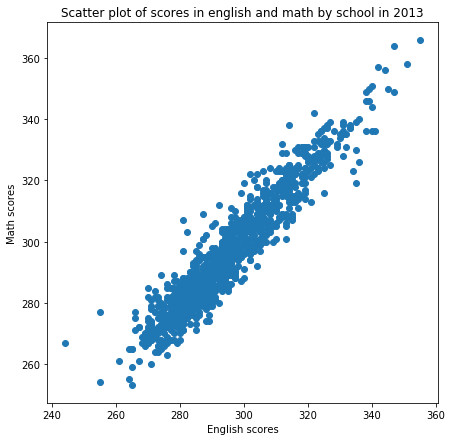

In [41]:
#2013
pl.figure(figsize=(7,7))
pl.scatter(engall2013["mean"], mathall2013["mean"])
pl.title("Scatter plot of scores in english and math by school in 2013")
pl.ylabel("Math scores")
pl.xlabel("English scores")

Text(0.5,0,'English scores')

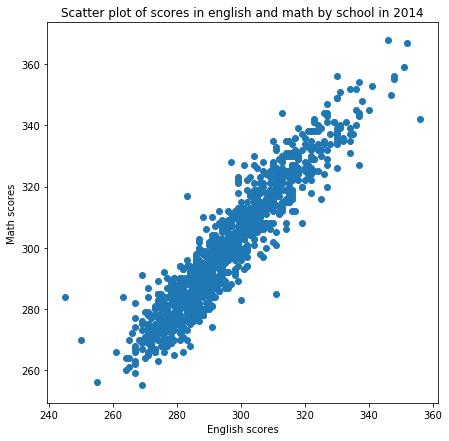

In [42]:
#2014
pl.figure(figsize=(7,7))
pl.scatter(engall2014["mean"], mathall2014["mean"])
pl.title("Scatter plot of scores in english and math by school in 2014")
pl.ylabel("Math scores")
pl.xlabel("English scores")

Text(0.5,0,'English scores')

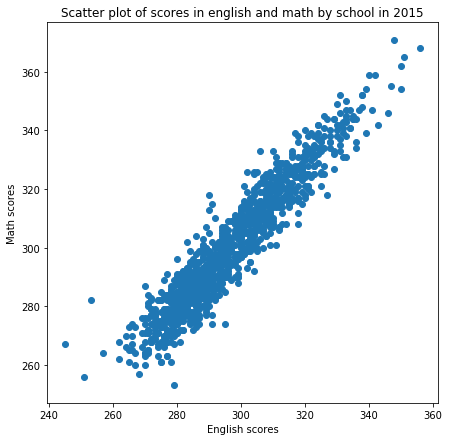

In [43]:
#for 2015 we must first merge english and math scores to drop additional school in math data
a = pd.merge(engall2015, mathall2015, on = "DBN")

pl.figure(figsize=(7,7))
pl.scatter(a["English Mean Score"], a["Math Mean Score"])
pl.title("Scatter plot of scores in english and math by school in 2015")
pl.ylabel("Math scores")
pl.xlabel("English scores")

In [44]:
#now we merge the test score data with the census tracts

In [46]:
ct = pd.read_csv("nyct2010.csv")

FileNotFoundError: File b'nyct2010.csv' does not exist

In [47]:
ct.columns

NameError: name 'ct' is not defined

In [48]:
ct.dtypes

NameError: name 'ct' is not defined

In [49]:
engall2013.columns

Index(['FISCAL_YEAR', 'ATS SYSTEM CODE', 'LOCATION_CODE', 'LOCATION_NAME',
       'BEDS NUMBER', 'MANAGED_BY_NAME', 'LOCATION_TYPE_DESCRIPTION',
       'LOCATION_CATEGORY_DESCRIPTION', 'GRADES_TEXT', 'GRADES_FINAL_TEXT',
       'OPEN_DATE', 'STATUS_DESCRIPTIONS', 'PRIMARY_BUILDING_CODE',
       'PRIMARY_ADDRESS_LINE_1', 'STATE_CODE', 'X_COORDINATE', 'Y_COORDINATE',
       'COMMUNITY_DISTRICT', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BOROUGH_BLOCK_LOT', 'NTA', 'NTA_NAME', 'PRINCIPAL_NAME',
       'PRINCIPAL_TITLE', 'PRINCIPAL_PHONE_NUMBER', 'FAX_NUMBER',
       'GEOGRAPHICAL_DISTRICT_CODE', 'ADMIN_DISTRICT_LOCATION_CODE',
       'ADMINISTRATIVE_DISTRICT_NAME', 'COMMUNITY_SCHOOL_SUP_NAME',
       'FIELD_SUPPORT_CENTER_NAME', 'FIELD_SUPPORT_CENTER_LEADER_NAME',
       'SCHOOL_SUPPORT_TEAM_NAME', 'SCHOOL_SUPPORT_TEAM_LEADER_NAME',
       'HIGHSCHOOL_NETWORK_LOCATION_CODE', 'HIGHSCHOOL_NETWORK_NAME',
       'HIGHSCHOOL_NETWORK_SUPERINTENDENT', 'Location 1', 'DBN', 'School Name',
       

In [50]:
#we must create BoroCT2010 in the test score data in order to merge

In [51]:
engall2013["Borough_Code"] = engall2013["LOCATION_CODE"].str[0]
engall2014["Borough_Code"] = engall2014["LOCATION_CODE"].str[0]
engall2015["Borough_Code"] = engall2015["LOCATION_CODE"].str[0]

mathall2013["Borough_Code"] = mathall2013["LOCATION_CODE"].str[0]
mathall2014["Borough_Code"] = mathall2014["LOCATION_CODE"].str[0]
mathall2015["Borough_Code"] = mathall2015["LOCATION_CODE"].str[0]

C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [52]:
def b_num(letter): 
    if letter == "K":
        return "3"
    elif letter == "X":
        return "2"
    elif letter == "Q":
        return "4"
    elif letter == "M":
        return "1"
    elif letter == "R":
        return "5"
engall2013["Borough_Code"].apply(b_num)
engall2014["Borough_Code"].apply(b_num)
engall2015["Borough_Code"].apply(b_num)

mathall2013["Borough_Code"].apply(b_num)
mathall2014["Borough_Code"].apply(b_num)
mathall2015["Borough_Code"].apply(b_num)

0        1
11       1
23       1
35       1
47       1
59       1
71       1
83       1
95       1
107      1
119      1
131      1
143      1
155      1
167      1
179      1
189      1
201      1
213      1
225      1
236      1
248      1
260      1
272      1
283      1
295      1
306      1
318      1
330      1
342      1
        ..
12785    5
12797    5
12809    5
12821    5
12833    5
12845    5
12857    5
12869    5
12881    5
12893    5
12905    3
12917    3
12929    3
12941    3
12953    3
12964    3
12976    3
12988    3
12999    3
13011    3
13023    3
13035    3
13046    3
13058    3
13069    3
13080    3
13092    3
13104    3
13116    3
13127    3
Name: Borough_Code, Length: 1125, dtype: object

In [53]:
#convert borough codes to borough numbers
engall2013["Borough_Num"] = engall2013["Borough_Code"].apply(b_num)
engall2014["Borough_Num"] = engall2014["Borough_Code"].apply(b_num)
engall2015["Borough_Num"] = engall2015["Borough_Code"].apply(b_num)

mathall2013["Borough_Num"] = mathall2013["Borough_Code"].apply(b_num)
mathall2014["Borough_Num"] = mathall2014["Borough_Code"].apply(b_num)
mathall2015["Borough_Num"] = mathall2015["Borough_Code"].apply(b_num)

C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [54]:
engall2013["CENSUS_TRACT"] = engall2013['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
engall2014["CENSUS_TRACT"] = engall2014['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
engall2015["CENSUS_TRACT"] = engall2015['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)

mathall2013["CENSUS_TRACT"] = mathall2013['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
mathall2014["CENSUS_TRACT"] = mathall2014['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)
mathall2015["CENSUS_TRACT"] = mathall2015['CENSUS_TRACT'].apply(lambda x: '{0:0>6}'.format(x)).astype(str)


C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [55]:
#create BoroCT2010
engall2013["BoroCT2010"] = engall2013["Borough_Num"] + engall2013["CENSUS_TRACT"]
engall2014["BoroCT2010"] = engall2014["Borough_Num"] + engall2014["CENSUS_TRACT"]
engall2015["BoroCT2010"] = engall2015["Borough_Num"] + engall2015["CENSUS_TRACT"]

mathall2013["BoroCT2010"] = mathall2013["Borough_Num"] + mathall2013["CENSUS_TRACT"]
mathall2014["BoroCT2010"] = mathall2014["Borough_Num"] + mathall2014["CENSUS_TRACT"]
mathall2015["BoroCT2010"] = mathall2015["Borough_Num"] + mathall2015["CENSUS_TRACT"]

C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [56]:
#convert to int
engall2013["BoroCT2010"] = engall2013["BoroCT2010"].astype(int)
engall2014["BoroCT2010"] = engall2014["BoroCT2010"].astype(int)
engall2015["BoroCT2010"] = engall2015["BoroCT2010"].astype(int)

mathall2013["BoroCT2010"] = mathall2013["BoroCT2010"].astype(int)
mathall2014["BoroCT2010"] = mathall2014["BoroCT2010"].astype(int)
mathall2015["BoroCT2010"] = mathall2015["BoroCT2010"].astype(int)

C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [57]:
#now merge with census tract data
engall2013 = pd.merge(ct, engall2013, on="BoroCT2010", how = "inner")
engall2014 = pd.merge(ct, engall2014, on="BoroCT2010", how = "inner")
engall2015 = pd.merge(ct, engall2015, on="BoroCT2010", how = "inner")

mathall2013 = pd.merge(ct, mathall2013, on="BoroCT2010", how = "inner")
mathall2014 = pd.merge(ct, mathall2014, on="BoroCT2010", how = "inner")
mathall2015 = pd.merge(ct, mathall2015, on="BoroCT2010", how = "inner")

NameError: name 'ct' is not defined

In [ ]:
print(engall2013.shape)
print(engall2014.shape)
print(engall2015.shape)

print(mathall2013.shape)
print(mathall2014.shape)
print(mathall2015.shape)

In [ ]:
#rename mean score column in each df
engall2013.rename(columns={"Mean Scale Score":"Eng2013_Mean"}, inplace=True)
engall2014.rename(columns={"Mean Scale Score":"Eng2014_Mean"}, inplace=True)
engall2015.rename(columns={"Mean Scale Score":"Eng2015_Mean"}, inplace=True)

mathall2013.rename(columns={"Mean Scale Score":"Math2013_Mean"}, inplace=True)
mathall2014.rename(columns={"Mean Scale Score":"Math2014_Mean"}, inplace=True)
mathall2015.rename(columns={"Mean Scale Score":"Math2015_Mean"}, inplace=True)

In [ ]:
#now combine enligsh and math scores in each year
scores2013 = pd.merge(engall2013,mathall2013[['ATS SYSTEM CODE','Math2013_Mean']],on='ATS SYSTEM CODE', how='left')
scores2014 = pd.merge(engall2014,mathall2014[['ATS SYSTEM CODE','Math2014_Mean']],on='ATS SYSTEM CODE', how='left')
scores2015 = pd.merge(engall2015,mathall2015[['ATS SYSTEM CODE','Math2015_Mean']],on='ATS SYSTEM CODE', how='left')

In [ ]:
scores2013.head()

In [ ]:
#shorten dataframes to include only columns we need
scores2013_short = scores2013[["the_geom", "BoroCode", "BoroCT2010", "LOCATION_NAME", "LOCATION_TYPE_DESCRIPTION",
                              "LOCATION_CATEGORY_DESCRIPTION", "X_COORDINATE", "Y_COORDINATE", "BOROUGH_BLOCK_LOT",
                              "DBN", "Number Tested", "Eng2013_Mean", "Math2013_Mean"]]

scores2014_short = scores2014[["the_geom", "BoroCode", "BoroCT2010", "LOCATION_NAME", "LOCATION_TYPE_DESCRIPTION",
                              "LOCATION_CATEGORY_DESCRIPTION", "X_COORDINATE", "Y_COORDINATE", "BOROUGH_BLOCK_LOT",
                              "DBN", "Number Tested", "Eng2014_Mean", "Math2014_Mean"]]

scores2015_short = scores2015[["the_geom", "BoroCode", "BoroCT2010", "LOCATION_NAME", "LOCATION_TYPE_DESCRIPTION",
                              "LOCATION_CATEGORY_DESCRIPTION", "X_COORDINATE", "Y_COORDINATE", "BOROUGH_BLOCK_LOT",
                              "DBN", "Number Tested", "Eng2015_Mean", "Math2015_Mean"]]

In [ ]:
print('the size of the 2013 tests data is', scores2013_short.shape)
print('the size of the 2014 tests data is', scores2014_short.shape)
print('the size of the 2015 tests data is', scores2015_short.shape)

In [ ]:
#in order to make graphs for analysis, we must re-merge with census data as a geo dataframe
ct = gp.GeoDataFrame.from_file("geo_export_7998d303-f449-4e75-9668-01d8bd50056f.shp")
ct.head()

In [ ]:
ct["boro_ct201"] = ct["boro_ct201"].astype(str)
scores2015_short["BoroCT2010"] = scores2015_short["BoroCT2010"].astype(str)
scores2013_short["BoroCT2010"] = scores2015_short["BoroCT2010"].astype(str)
scores2014_short["BoroCT2010"] = scores2015_short["BoroCT2010"].astype(str)

In [ ]:
graphs2013 = pd.merge(scores2013_short, ct, left_on="BoroCT2010", right_on="boro_ct201")
graphs2014 = pd.merge(scores2014_short, ct, left_on="BoroCT2010", right_on="boro_ct201")
graphs2015 = pd.merge(scores2015_short, ct, left_on="BoroCT2010", right_on="boro_ct201")

In [ ]:
print(graphs2013.shape)
print(graphs2014.shape)
print(graphs2015.shape)

In [ ]:
graphs2013.head()

In [ ]:
geoscores2013_short = gp.GeoDataFrame(graphs2013)
geoscores2014_short = gp.GeoDataFrame(graphs2014)
geoscores2015_short = gp.GeoDataFrame(graphs2015)

In [ ]:
#graphing 2013 mean English scores by census tract
cp.choroplethNYC(geoscores2013_short, column="Eng2013_Mean", color="k",cmap="viridis", edgecolor="k", lw=0.5);

In [ ]:
#graphing 2013 mean math scores by census tract
cp.choroplethNYC(geoscores2015_short, column="Math2015_Mean", color="k",cmap="viridis", edgecolor="k", lw=0.5);

In [ ]:
#now we can merge test scores by census tract with noise complaints by census tract
#load in noise complaint data
noise13 = pd.read_csv("noisebyct2013.csv")
noise14 = pd.read_csv("noisebyct2014.csv")
noise15 = pd.read_csv("noisebyct2015.csv")

In [ ]:
print(noise13.shape)
print(noise14.shape)
print(noise15.shape)

In [ ]:
#shorten noise complaints data to only contain census tract, number of complaints, and complaint density
noise13 = noise13[["boro_ct201", "count_vals", "count_vals_density"]]
noise14 = noise14[["boro_ct201", "count_vals", "count_vals_density"]]
noise15 = noise15[["boro_ct201", "count_vals", "count_vals_density"]]

In [ ]:
print(noise13.shape)
print(noise14.shape)
print(noise15.shape)

In [ ]:
#convert census tracts to string
noise13["boro_ct201"] = noise13["boro_ct201"].astype(str)
noise14["boro_ct201"] = noise14["boro_ct201"].astype(str)
noise15["boro_ct201"] = noise15["boro_ct201"].astype(str)

In [ ]:
scores2013_final = pd.merge(noise13, geoscores2013_short, left_on="boro_ct201", right_on="BoroCT2010")
scores2014_final = pd.merge(noise14, geoscores2014_short, left_on="boro_ct201", right_on="BoroCT2010")
scores2015_final = pd.merge(noise15, geoscores2015_short, left_on="boro_ct201", right_on="BoroCT2010")

In [ ]:
scores2013_final.head()

In [ ]:
#convert to geo dataframe for mapping 
geoscores2015_final = gp.GeoDataFrame(scores2015_final)
geoscores2013_final = gp.GeoDataFrame(scores2013_final)
geoscores2014_final = gp.GeoDataFrame(scores2014_final)

In [ ]:
#convert all test scores to int
geoscores2013_final["Eng2013_Mean"] = geoscores2013_final["Eng2013_Mean"].astype(int)
geoscores2014_final["Eng2014_Mean"] = geoscores2014_final["Eng2014_Mean"].astype(int)
geoscores2015_final["Eng2015_Mean"] = geoscores2015_final["Eng2015_Mean"].astype(int)

geoscores2013_final["Math2013_Mean"] = geoscores2013_final["Math2013_Mean"].astype(int)
geoscores2014_final["Math2014_Mean"] = geoscores2014_final["Math2014_Mean"].astype(int)
geoscores2015_final["Math2015_Mean"] = geoscores2015_final["Math2015_Mean"].astype(int)

In [ ]:
#now create graphs to examine the effect noise complaints on test scores
import matplotlib.pyplot as plt

In [ ]:
math2013_trend = sn.jointplot("count_vals_density", "Math2013_Mean", data =geoscores2013_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
math2013_trend.fig.suptitle('Effect of Noise Complaints of 2013 Math Scores', fontsize=20)

In [ ]:
eng2013_trend = sn.jointplot("count_vals_density", "Eng2013_Mean", data =geoscores2013_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
eng2013_trend.fig.suptitle('Effect of Noise Complaints of 2013 English Scores', fontsize=20)

In [ ]:
math2014_trend = sn.jointplot("count_vals_density", "Math2014_Mean", data =geoscores2014_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
math2014_trend.fig.suptitle('Effect of Noise Complaints of 2014 Math Scores', fontsize=20)

In [ ]:
eng2014_trend = sn.jointplot("count_vals_density", "Eng2014_Mean", data =geoscores2014_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
eng2014_trend.fig.suptitle('Effect of Noise Complaints of 2014 English Scores', fontsize=20)

In [ ]:
math2015_trend = sn.jointplot("count_vals_density", "Math2015_Mean", data =geoscores2015_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
math2015_trend.fig.suptitle('Effect of Noise Complaints of 2015 Math Scores', fontsize=20)

In [ ]:
eng2015_trend = sn.jointplot("count_vals_density", "Eng2015_Mean", data =geoscores2015_final, kind="reg",
                  joint_kws={"line_kws":{"color":"red"}}).set_axis_labels('Density of Noise Complaints', 'Mean Test Score', fontsize=16)
plt.subplots_adjust(top=0.9)
eng2015_trend.fig.suptitle('Effect of Noise Complaints of 2015 English Scores', fontsize=20)

In [ ]:
#save dataframes to csv
geoscores2013_final.to_csv("scores2013.csv")
geoscores2014_final.to_csv("scores2014.csv")
geoscores2015_final.to_csv("scores2015.csv")

# SECTION 3. LODES DATA MUNGING 

In [59]:
#Load data downloaded from LODES (source: https://lehd.ces.census.gov/data/lodes/LODES7/ny/rac/)
LODES2013 = pd.read_csv("ny_rac_S000_JT00_2013.csv") #2013 all jobs
LODES2014 = pd.read_csv("ny_rac_S000_JT00_2014.csv") #2014 all jobs
LODES2015 = pd.read_csv("ny_rac_S000_JT00_2015.csv") #2015 all jobs

In [60]:
#Create the Census Tract variable for merging
LODES2013['Census Tract'] = LODES2013['h_geocode'].apply(lambda x: str(x)[5:11])
LODES2014['Census Tract'] = LODES2014['h_geocode'].apply(lambda x: str(x)[5:11])
LODES2015['Census Tract'] = LODES2015['h_geocode'].apply(lambda x: str(x)[5:11])

In [61]:
# Create aggregated Income variable for each census tract

##2013
GroupSum2013 = LODES2013.groupby(['Census Tract']).agg({'C000': sum,
                                         'CE01': sum,
                                         'CE02': sum,
                                         'CE03': sum})
GroupSum2013['ct']=GroupSum2013.index
GroupSum2013['CE01Percent'] = GroupSum2013['CE01']/GroupSum2013['C000']
GroupSum2013['CE02Percent'] = GroupSum2013['CE02']/GroupSum2013['C000']
GroupSum2013['CE03Percent'] = GroupSum2013['CE03']/GroupSum2013['C000']
GroupSum2013.columns = ['CE01totcounts', 'CE02totcounts','CE03totcounts','C000totcounts','ct','CE01Percent','CE02Percent','CE03Percent']
LODES2013merge = pd.merge(GroupSum2013, LODES2013, left_on='ct', right_on='Census Tract')

##2014
GroupSum2014 = LODES2014.groupby(['Census Tract']).agg({'C000': sum,
                                         'CE01': sum,
                                         'CE02': sum,
                                         'CE03': sum})
GroupSum2014['ct']=GroupSum2014.index
GroupSum2014['CE01Percent'] = GroupSum2014['CE01']/GroupSum2014['C000']
GroupSum2014['CE02Percent'] = GroupSum2014['CE02']/GroupSum2014['C000']
GroupSum2014['CE03Percent'] = GroupSum2014['CE03']/GroupSum2014['C000']
GroupSum2014.columns = ['CE01totcounts', 'CE02totcounts','CE03totcounts','C000totcounts','ct','CE01Percent','CE02Percent','CE03Percent']
LODES2014merge = pd.merge(GroupSum2014, LODES2014, left_on='ct', right_on='Census Tract')

##2015
GroupSum2015 = LODES2015.groupby(['Census Tract']).agg({'C000': sum,
                                         'CE01': sum,
                                         'CE02': sum,
                                         'CE03': sum})
GroupSum2015['ct']=GroupSum2015.index
GroupSum2015['CE01Percent'] = GroupSum2015['CE01']/GroupSum2015['C000']
GroupSum2015['CE02Percent'] = GroupSum2015['CE02']/GroupSum2015['C000']
GroupSum2015['CE03Percent'] = GroupSum2015['CE03']/GroupSum2015['C000']
GroupSum2015.columns = ['CE01totcounts', 'CE02totcounts','CE03totcounts','C000totcounts','ct','CE01Percent','CE02Percent','CE03Percent']
LODES2015merge = pd.merge(GroupSum2015, LODES2015, left_on='ct', right_on='Census Tract')

In [62]:
LODES2015merge.head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent,h_geocode,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02,createdate,Census Tract
0,15290,3319,3926,8045,000100,0.21707,0.256769,0.526161,360010001001008,14,3,8,3,3,9,2,0,0,0,0,2,1,1,0,0,0,0,0,0,0,2,4,0,1,1,2,10,3,1,0,0,0,14,0,1,4,3,3,6,8,20170919,000100
1,15290,3319,3926,8045,000100,0.21707,0.256769,0.526161,360010001001009,14,3,9,2,6,6,2,0,0,0,0,1,1,2,0,0,1,1,0,0,0,0,4,0,1,1,2,5,7,0,1,0,1,12,2,3,4,3,1,5,9,20170919,000100
2,15290,3319,3926,8045,000100,0.21707,0.256769,0.526161,360010001001010,16,5,8,3,3,6,7,0,0,0,2,0,0,3,1,0,1,1,1,0,0,1,2,0,0,2,2,9,6,0,1,0,0,16,0,1,6,3,1,10,6,20170919,000100
3,15290,3319,3926,8045,000100,0.21707,0.256769,0.526161,360010001001011,56,16,38,2,14,30,12,0,0,0,1,1,2,4,2,3,1,0,4,1,6,3,16,1,3,2,6,30,23,0,2,0,1,43,13,7,15,10,8,23,33,20170919,000100
4,15290,3319,3926,8045,000100,0.21707,0.256769,0.526161,360010001001012,36,12,18,6,13,14,9,0,0,0,2,0,0,2,0,0,3,1,1,2,3,3,8,1,2,1,7,11,21,0,1,1,2,33,3,3,5,11,5,18,18,20170919,000100


In [63]:
#Export to csv
LODES2013merge.to_csv("LODES2013.csv")
LODES2014merge.to_csv("LODES2014.csv")
LODES2015merge.to_csv("LODES2015.csv")

#### Create Artificial Group Labels

In [64]:
# Artificial Group Labels
# If percentage of people living in an area is >30%, then the group labels will be as follows:

# >30% in CE01 only = 'Mostly Poor'/0
GroupSum2015[(GroupSum2015['CE01Percent'] >= 0.3) & (GroupSum2015['CE02Percent'] < 0.3) & (GroupSum2015['CE03Percent'] < 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
003802,314,190,69,55,003802,0.605096,0.219745,0.175159
053300,1642,774,483,385,053300,0.471376,0.294153,0.234470


In [65]:
# >30% in CE01 and CE02 only = 'Mid-Poor'/1
GroupSum2015[(GroupSum2015['CE01Percent'] >= 0.3) & (GroupSum2015['CE02Percent'] >= 0.3) & (GroupSum2015['CE03Percent'] < 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
000110,1101,366,442,293,000110,0.332425,0.401453,0.266122
001701,1066,344,476,246,001701,0.322702,0.446529,0.230769
002400,6601,1985,2666,1950,002400,0.300712,0.403878,0.295410
002500,7311,2289,3131,1891,002500,0.313090,0.428259,0.258651
002502,767,266,290,211,002502,0.346806,0.378096,0.275098


In [66]:
# >30% in CE01 and CE03 only = 'Gentrified'/2
GroupSum2015[(GroupSum2015['CE01Percent'] >= 0.3) & (GroupSum2015['CE02Percent'] < 0.3) & (GroupSum2015['CE03Percent'] >= 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
009107,2347,730,703,914,009107,0.311035,0.299531,0.389433
009109,1679,504,451,724,009109,0.300179,0.268612,0.431209
009110,481,150,125,206,009110,0.311850,0.259875,0.428274
009112,1080,348,318,414,009112,0.322222,0.294444,0.383333
011506,1439,524,425,490,011506,0.364142,0.295344,0.340514


In [67]:
# >30% in CE01 and CE02 and CE03 = 'Mixed'/3
GroupSum2015[(GroupSum2015['CE01Percent'] >= 0.3) & (GroupSum2015['CE02Percent'] >= 0.3) & (GroupSum2015['CE03Percent'] >= 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
000104,86,26,34,26,000104,0.302326,0.395349,0.302326
000404,588,178,182,228,000404,0.302721,0.309524,0.387755
004601,1474,470,462,542,004601,0.318860,0.313433,0.367707
006102,730,243,256,231,006102,0.332877,0.350685,0.316438
006601,985,324,359,302,006601,0.328934,0.364467,0.306599


In [68]:
# >30% in CE02 only = 'Mostly Middle'/4
GroupSum2015[(GroupSum2015['CE01Percent'] < 0.3) & (GroupSum2015['CE02Percent'] >= 0.3) & (GroupSum2015['CE03Percent'] < 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
004001,3149,924,1294,931,004001,0.293426,0.410924,0.295649
004401,3304,966,1357,981,004401,0.292373,0.410714,0.296913
008701,1662,480,780,402,008701,0.288809,0.469314,0.241877
017701,1486,423,699,364,017701,0.284657,0.470390,0.244953
017901,2008,550,947,511,017901,0.273904,0.471614,0.254482


In [69]:
# >30% in CE02 and CE03 only = 'Mid-Rich'/5
GroupSum2015[(GroupSum2015['CE01Percent'] < 0.3) & (GroupSum2015['CE02Percent'] >= 0.3) & (GroupSum2015['CE03Percent'] >= 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
000101,1945,458,801,686,000101,0.235476,0.411825,0.352699
000103,2331,608,816,907,000103,0.260832,0.350064,0.389103
000200,13941,4028,5531,4382,000200,0.288932,0.396743,0.314325
000201,3811,974,1442,1395,000201,0.255576,0.378378,0.366046
000203,1241,243,382,616,000203,0.195810,0.307816,0.496374


In [70]:
# >30% in CE03 only = 'Mostly-Rich'/6
GroupSum2015[(GroupSum2015['CE01Percent'] < 0.3) & (GroupSum2015['CE02Percent'] < 0.3) & (GroupSum2015['CE03Percent'] >= 0.3)].head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts,ct,CE01Percent,CE02Percent,CE03Percent
Census Tract,,,,,,,,
000100,15290,3319,3926,8045,000100,0.217070,0.256769,0.526161
000202,4469,1032,1330,2107,000202,0.230924,0.297606,0.471470
000301,2036,332,310,1394,000301,0.163065,0.152259,0.684676
000502,4229,992,1157,2080,000502,0.234571,0.273587,0.491842
000700,23935,4877,6045,13013,000700,0.203760,0.252559,0.543681


In [71]:
# Attach these as a created variable
def TractLabelling(data):
    if (data['CE01Percent'] >= 0.3) & (data['CE02Percent'] < 0.3) & (data['CE03Percent'] < 0.3):
        return 0
    if (data['CE01Percent'] >= 0.3) & (data['CE02Percent'] >= 0.3) & (data['CE03Percent'] < 0.3):
        return 1
    if (data['CE01Percent'] >= 0.3) & (data['CE02Percent'] < 0.3) & (data['CE03Percent'] >= 0.3):
        return 2
    if (data['CE01Percent'] >= 0.3) & (data['CE02Percent'] >= 0.3) & (data['CE03Percent'] >= 0.3):
        return 3
    if (data['CE01Percent'] < 0.3) & (data['CE02Percent'] >= 0.3) & (data['CE03Percent'] < 0.3):
        return 4
    if (data['CE01Percent'] < 0.3) & (data['CE02Percent'] >= 0.3) & (data['CE03Percent'] >= 0.3):
        return 5
    if (data['CE01Percent'] < 0.3) & (data['CE02Percent'] < 0.3) & (data['CE03Percent'] >= 0.3):
        return 6

In [72]:
GroupSum2013['TractLabel'] = GroupSum2013.apply(TractLabelling,axis=1)
GroupSum2014['TractLabel'] = GroupSum2014.apply(TractLabelling,axis=1)
GroupSum2015['TractLabel'] = GroupSum2015.apply(TractLabelling,axis=1)

In [73]:
# Export to csv
GroupSum2013.to_csv("LODES2013Sum.csv")
GroupSum2014.to_csv("LODES2014Sum.csv")
GroupSum2015.to_csv("LODES2015Sum.csv")

#### K-MEANS Clustering

In [75]:
#standardize the features
features = ['CE01totcounts', 'CE02totcounts', 'CE03totcounts', 'C000totcounts']
x = GroupSum2013.loc[:, features].values
x = StandardScaler().fit_transform(x)

C:\Users\james\Anaconda2\envs\base python 3.6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [76]:
pd.DataFrame(data = x, columns = features).head()

,CE01totcounts,CE02totcounts,CE03totcounts,C000totcounts
0,3.074561,3.057734,2.835156,3.044611
1,-0.339897,-0.306829,-0.208017,-0.419329
2,-0.154255,-0.053239,0.018590,-0.305619
3,-1.004157,-0.988610,-1.003907,-0.949975
4,-0.515413,-0.342858,-0.348404,-0.676931


In [77]:
#PCA to 2 dimensions
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf['TractLabel'] = GroupSum2013['TractLabel'].tolist()

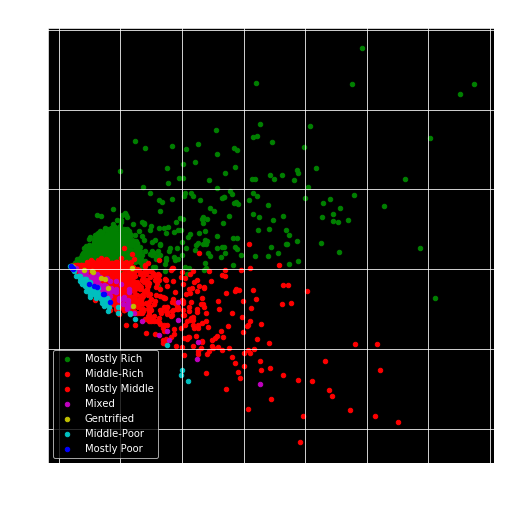

In [78]:
# Visualize with imputed labels
fig = plt.figure(figsize = (8,8))
plt.style.use('dark_background')
color = ['b', 'c', 'y', 'm', 'r','purple','g']
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 6]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 6]
               , c = color[6]
               , s = 20
               , label = "Mostly Rich")
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 5]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 5]
               , c = color[4]
               , s = 20
               , label = "Middle-Rich")
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 4]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 4]
               , c = color[4]
               , s = 20
               , label = "Mostly Middle")
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 3]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 3]
               , c = color[3]
               , s = 20
               , label = "Mixed")
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 2]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 2]
               , c = color[2]
               , s = 20
               , label = "Gentrified")
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 1]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 1]
               , c = color[1]
               , s = 20
               , label = "Middle-Poor")
ax.scatter(principalDf['principal component 1'][principalDf['TractLabel'] == 0]
               , principalDf['principal component 2'][principalDf['TractLabel'] == 0]
               , c = color[0]
               , s = 20
               , label = "Mostly Poor")
ax.grid()
ax.legend(loc='lower left')

The PC are unfortunately not very well seperated, which does not bode well for the clustering algorithms. I am attempting k-means below, but with not much expectations.

For n_clusters = 2 The average silhouette_score is : 0.6683558575974001


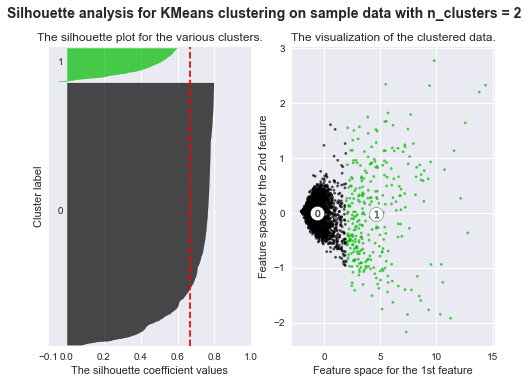

For n_clusters = 3 The average silhouette_score is : 0.6119799732441896


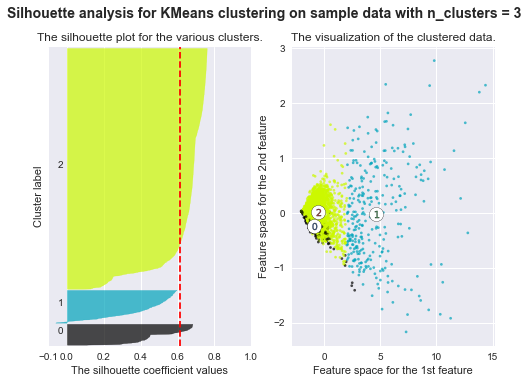

For n_clusters = 4 The average silhouette_score is : 0.5684052177623067


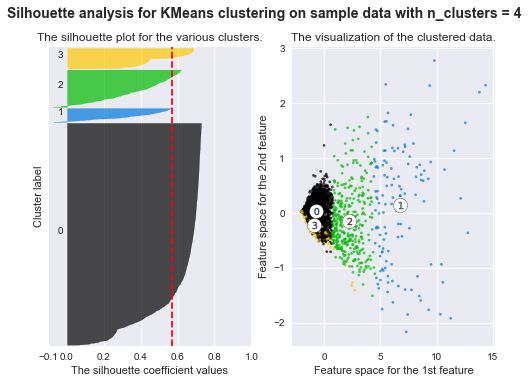

For n_clusters = 5 The average silhouette_score is : 0.43726598310397763


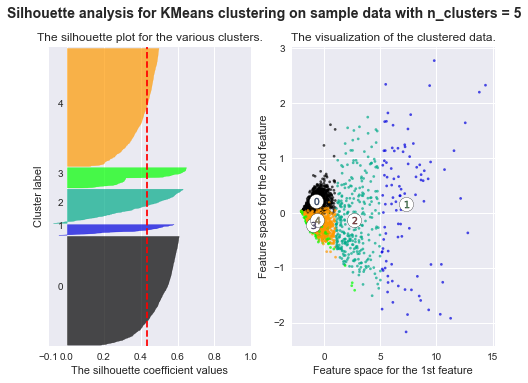

For n_clusters = 6 The average silhouette_score is : 0.45825450635768217


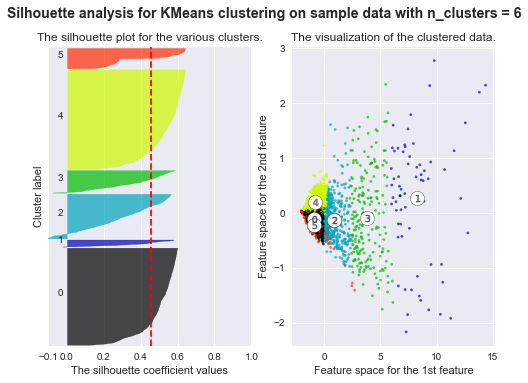

In [82]:
plt.style.use('seaborn')
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(principalDf) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(principalDf)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(principalDf, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(principalDf, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(principalDf.iloc[:, 0], principalDf.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

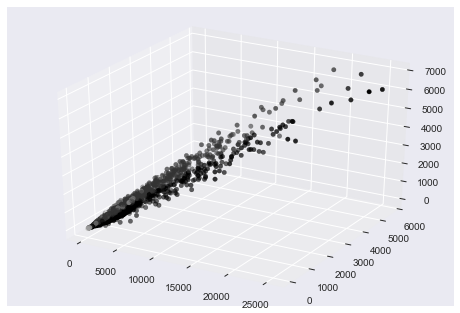

In [83]:
ax = plt.subplot(111, projection='3d')
ax.scatter3D(GroupSum2013['CE01totcounts'], GroupSum2013['CE02totcounts'], GroupSum2013['CE03totcounts'], c=GroupSum2013['TractLabel'])

# SECTION 4.  FINAL MERGE  AND MODELS

In [ ]:
#read in final test scores and lodes data

scores2013 = pd.read_csv("scores2013.csv")
scores2014 = pd.read_csv("scores2014.csv")
scores2015 = pd.read_csv("scores2015.csv")

lodes2013 = pd.read_csv("LODES2013Sum.csv", converters={'Census Tract': lambda x: str(x)})
lodes2014 = pd.read_csv("LODES2014Sum.csv", converters={'Census Tract': lambda x: str(x)})
lodes2015 = pd.read_csv("LODES2015Sum.csv", converters={'Census Tract': lambda x: str(x)})

In [ ]:
lodes2013.shape

In [ ]:
scores2013.columns

In [ ]:
#merge 
lodes_scores2013 = pd.merge(lodes2013, scores2013, left_on="ct", right_on="ct2010", how = "right")
lodes_scores2014 = pd.merge(lodes2014, scores2014, left_on="ct", right_on="ct2010", how = "right")
lodes_scores2015 = pd.merge(lodes2015, scores2015, left_on="ct", right_on="ct2010", how = "right")

In [ ]:
lodes_scores2013.shape

In [ ]:
lodes_scores2013.columns

In [ ]:
lodes_scores2013.head()


In [ ]:
MathReg2013 = smf.ols("Math2013_Mean~count_vals_density + C(TractLabel)", data=lodes_scores2013).fit()
MathReg2013.summary()

In [ ]:
EngReg2013 = smf.ols("Eng2013_Mean~count_vals_density + C(TractLabel)", data=lodes_scores2013).fit()
EngReg2013.summary()

In [ ]:
MathReg2014 = smf.ols("Math2014_Mean~count_vals_density + C(TractLabel)", data=lodes_scores2014).fit()
MathReg2014.summary()

In [ ]:
EngReg2014 = smf.ols("Eng2014_Mean~count_vals_density + C(TractLabel)", data=lodes_scores2014).fit()
EngReg2014.summary()

In [ ]:
MathReg2015 = smf.ols("Math2015_Mean~count_vals_density + C(TractLabel)", data=lodes_scores2015).fit()
MathReg2015.summary()

In [ ]:
EngReg2015 = smf.ols("Eng2015_Mean~count_vals_density + C(TractLabel)", data=lodes_scores2015).fit()
EngReg2015.summary()